In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use('ggplot')

idx = pd.IndexSlice

root = Path.cwd().parent.parent.parent / "cluster_data"

In [2]:
def get_data(mode, op):

    if mode == "chp" or mode == "dh":
        df = pd.read_csv(root / f"{mode}_data" / f"csvs_{op}" / "nodal_capacities.csv", index_col=[0,1,2], header=[0,1,2,3,4,5,6])
    elif mode == "elec":
        df = pd.read_csv(root / f"{mode}_data" / "csvs" / "nodal_capacities.csv", index_col=[0,1,2], header=[0,1,2,3,4,5,6])


    df = df.groupby(level=[0,2]).sum()
    df.columns = df.columns.droplevel([0,1,2,3,5])

    df["carrier"] = df.index.get_level_values(1)
    df.index = df.index.droplevel(1)

    df.index += " " + df.carrier

    df = df.loc[df.carrier.isin(["geothermal heat", "geothermal heat elec"])]
    df.drop("carrier", axis=1, inplace=True)
    df = df.loc[:, idx[:, op]]
    df.columns = df.columns.droplevel(1)

    return df.loc["links geothermal heat"].mul(0.5).mul(1e-3)

elec_static = get_data("elec", "static")
elec_flex = get_data("elec", "flex")

[1000. 1500. 2000.]


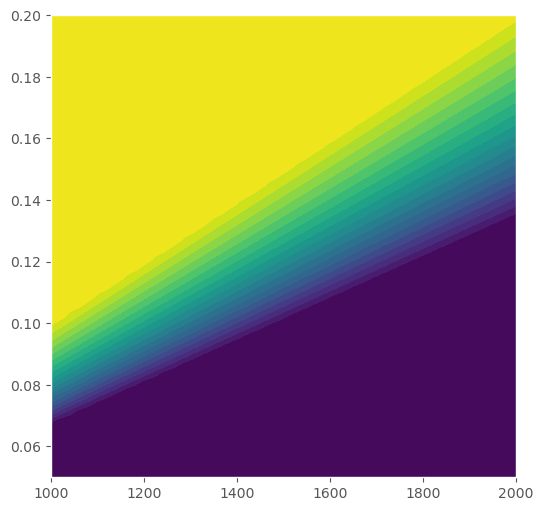

In [22]:
elec_static

def make_efficiency_mesh(
        base_value,
        min_value,
        max_values,
        steps,
        capex,
        z
    ):

    etas = np.linspace(min_value, max_values, steps)

    print(capex)
    capexes = np.linspace(min(capex), max(capex), steps)

    capexes, etas = np.meshgrid(capexes, etas)

    final_z = np.zeros((steps, steps))
    for i, eta in enumerate(etas):
        
        local_capexes = capex * eta.mean() / base_value

        final_z[i] = np.interp(capexes[i], local_capexes, z)

    fig, ax = plt.subplots(figsize=(6, 6))
    # ax.contourf(etas, capexes, final_z, levels=20, cmap="viridis")
    ax.contourf(capexes, etas, final_z, levels=20, cmap="viridis")
    plt.show()


make_efficiency_mesh(
    0.1,
    0.05,
    0.2,
    50,
    elec_static.index.values.astype(float),
    elec_static.values,
    )